[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MNoichl/simple_teams/blob/main/team_reasoning_in_prisoners_full_replacement_replicator_dyn.ipynb)

# Team-reasoning in the Prisoners-Dilemma with replicator dynamics


This notebook implements a simulation of the PD game using mesa. In the simulation, agents, which are either team-reasoners or not, are randomly assigned other players, with whom they play the PD. The players collected utilities are then transformed into the new ratio of team reasoners, in a manner inspired by Armadae and Lempert, 2015.

In [1]:
# uncomment these lines below, when running in colab:
# !pip install nashpy==0.0.20
# !pip install mesa
# !git clone https://github.com/MNoichl/simple_teams
# %cd simple_teams


# game-theoretic:
import nashpy as nash

# mesa:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# standards:
import numpy as np
import pandas as pd
import tqdm

# graphics:
import seaborn as sns
import matplotlib.pyplot as plt

# code formatting – comment out when using colab:
%load_ext nb_black


<IPython.core.display.Javascript object>

## To-Do
1. Pairwise scheduling of agents? (Via one agent!)
1. error handling für keine Team-reasoner mehr.
1. Replicator dynamics [Leyla will tell me] 
2. Add different games 
2. Multiple games
3. Endogenize probability through bayesian learning
4. Put agents eg. on networks
5. different matrix for learning of TRs? 

In [2]:
# A = np.array([[5-3, 5-0], [5-5, 5-1]])
# B = np.array([[5-3, 5-5], [5-0, 5-1]])

A = np.array([[3, 1], [4, 2]])
B = np.array([[3, 4], [1, 2]])


prisoners_dilemma = nash.Game(A, B)

equilibria = prisoners_dilemma.support_enumeration()
for eq in equilibria: #check equilibria
    print(eq)


(array([0., 1.]), array([0., 1.]))


<IPython.core.display.Javascript object>

In [3]:
prisoners_dilemma  # [[0, 1], [1, 0]]

Bi matrix game with payoff matrices:

Row player:
[[3 1]
 [4 2]]

Column player:
[[3 4]
 [1 2]]

<IPython.core.display.Javascript object>

In [4]:
prisoners_dilemma[[0, 1], [0, 1]]

array([2, 2])

<IPython.core.display.Javascript object>

In [7]:
def random_argmax(b):  # argmax with tiebreaking.
    return np.random.choice(np.flatnonzero(b == np.max(b)))


# global actual_proportion_team_reasoners


class MyAgent(Agent):
    """ """

    def __init__(
        self, unique_id, model, team_reasoner=False, probability_team_reasoning=0.9
    ):
        super().__init__(unique_id, model)

        self.team_reasoner = team_reasoner
        self.alive = True
        self.gathered_utility = 0
        self.probability_team_reasoning = probability_team_reasoning
        self.team_reasoning_counter = 0

    def step(self):
        #         The agent's step will go here.
        other_player = self.random.choice(self.model.schedule.agents)

        #         print(self.model.game)
        choices = [
            self.reason(
                player,
                player.team_reasoner,
                player.model.game,
                player.probability_team_reasoning,
            )
            for player in [self, other_player]
        ]
        payoff = self.model.game[list(choices[0]), list(choices[1])]
        self.gathered_utility += payoff[0]
        pass

    def reason(self, player, team_reasoner, game, probability_team_reasoning):
        if team_reasoner == True:

            if np.random.rand() < probability_team_reasoning:
                #                 choice = random_argmax([0, 1])
                #                 strat = np.zeros(2)
                #                 strat[choice] = 1
                if player == self:
                    self.team_reasoning_counter += 1  # Hic sunt draconis!
                return [1, 0]
            else:
                #                 choice = random_argmax([1, 0])
                #                 strat = np.zeros(2)
                #                 strat[choice] = 1
                return [0, 1]
        else:
            #             choice = random_argmax([1, 0])
            #             strat = np.zeros(2)
            #             strat[choice] = 1
            return [0, 1]


class MyModel(Model):
    """"""

    def __init__(
        self, proportion_team_reasoners, n_agents, game, probability_team_reasoning
    ):
        super().__init__()

        self.n_agents = n_agents
        self.schedule = RandomActivation(self)
        self.game = game
        self.probability_team_reasoning = probability_team_reasoning
        self.make_n_agents(self.n_agents, proportion_team_reasoners)
        self.proportion_team_reasoners = proportion_team_reasoners

        #         global actual_proportion_team_reasoners
        #         actual_proportion_team_reasoners = proportion_team_reasoners

        agent_reporters = {
            "team_reasoner": lambda a: getattr(a, "team_reasoner", None),
            "gathered_utility": lambda a: getattr(a, "gathered_utility", None),
            "alive": lambda a: getattr(a, "alive", None),
            "team_reasoning_counter": lambda a: getattr(
                a, "team_reasoning_counter", None
            ),
        }

        model_reporters = {
            "proportion_team_reasoners": lambda a: getattr(
                a, "proportion_team_reasoners", None
            ),
        }

        self.datacollector = DataCollector(
            model_reporters=model_reporters, agent_reporters=agent_reporters
        )

    def make_n_agents(self, n_agents, proportion_team_reasoners, starting_no=0):

        team_reason_until = int(proportion_team_reasoners * n_agents)
        for ix, i in enumerate(range(self.n_agents)):
            if ix < team_reason_until:
                a = MyAgent(
                    unique_id=i + starting_no,
                    model=self,
                    team_reasoner=True,
                    probability_team_reasoning=self.probability_team_reasoning,
                )
            else:
                a = MyAgent(
                    unique_id=i + starting_no,
                    model=self,
                    team_reasoner=False,
                    probability_team_reasoning=self.probability_team_reasoning,
                )

            self.schedule.add(a)

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

        replication_frame = pd.DataFrame(
            [
                [agent.gathered_utility for agent in model.schedule.agents],
                [agent.team_reasoner for agent in model.schedule.agents],
            ]
        ).T
        replication_frame.columns = ["gathered_utility", "team_reasoner"]
        #         display(replication_frame)
        # average vs. expected utility
        ratio_dict = dict(
            pd.to_numeric(replication_frame["gathered_utility"])
            .groupby(replication_frame["team_reasoner"])
            .mean()
        )
#################### CLEAN THIS UP ####################
        non_tr_utils = ratio_dict.get(False)
        tr_utils = ratio_dict.get(True)

        #         non_tr_utils = (
        #             1 - self.proportion_team_reasoners
        #         ) * 2 + self.proportion_team_reasoners * 4  # change to nash
        #         tr_utils = (
        #             1 - self.proportion_team_reasoners
        #         ) * 1 + self.proportion_team_reasoners * 3  # change to nash

        #         average_utility = pd.to_numeric(replication_frame["gathered_utility"]).mean()
        actual_proportion_team_reasoners = self.proportion_team_reasoners
        delta_share = (
            actual_proportion_team_reasoners
            * (1 - actual_proportion_team_reasoners)
            * (
                (non_tr_utils - tr_utils)
                / (
                    (actual_proportion_team_reasoners * tr_utils)
                    + ((1 - actual_proportion_team_reasoners) * non_tr_utils)
                )
            )
        )
        #         print(delta_share)

        new_tr_share = actual_proportion_team_reasoners - delta_share
        #         print(new_tr_share)
        max_id = np.max([agent.unique_id for agent in model.schedule.agents])

        for agent in model.schedule.agents:
            self.schedule.remove(agent)

        self.make_n_agents(self.n_agents, new_tr_share, max_id + 1)
        #         print("############")
        #         print(self.proportion_team_reasoners)
        self.proportion_team_reasoners = new_tr_share


#         print(self.proportion_team_reasoners)


#         return self.proportion_team_reasoner


model = MyModel(
    proportion_team_reasoners=0.6,
    n_agents=100,
    game=prisoners_dilemma,
    probability_team_reasoning=0.5,
)

for t in tqdm.tqdm_notebook(range(300)):
    model.step()

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:190: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/300 [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

<IPython.core.display.Javascript object>

In [8]:
model.proportion_team_reasoners

0.009252251140965445

<IPython.core.display.Javascript object>

In [9]:
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

<IPython.core.display.Javascript object>

In [10]:
agent_df = agent_df.reset_index()

<IPython.core.display.Javascript object>

In [11]:
agent_df

,Step,AgentID,team_reasoner,gathered_utility,alive,team_reasoning_counter
0,1,0,True,1,True,1
1,1,1,True,2,True,0
2,1,2,True,1,True,1
3,1,3,True,1,True,1
4,1,4,True,2,True,0
...,...,...,...,...,...,...
1995,20,1995,False,2,True,0
1996,20,1996,False,2,True,0
1997,20,1997,False,2,True,0
1998,20,1998,False,2,True,0


<IPython.core.display.Javascript object>

Text(0.0, 1.0, 'Fraction of team-reasoners over 20 iterations of Prisoners Dilemma')

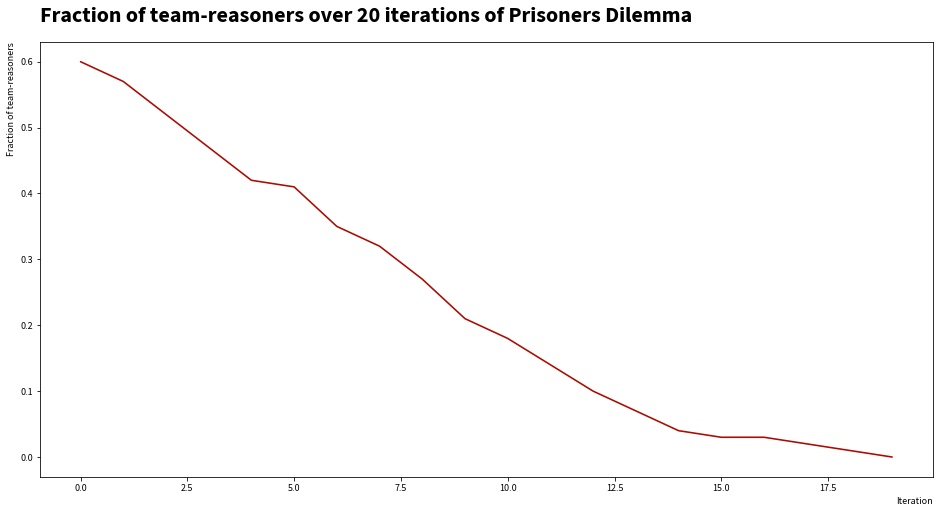

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use("opinions.mplstyle")

total_amount_of_agents = agent_df.groupby("Step")["alive"].sum()
total_amount_of_team_reasoners = agent_df.groupby("Step")["team_reasoner"].sum()

plt.plot(
    [y / x for x, y in zip(total_amount_of_agents, total_amount_of_team_reasoners)],
    linewidth=1.6,
    c="#ab0b00",
    alpha=1,
)

plt.xlabel("Iteration")
plt.ylabel("Fraction of team-reasoners")
plt.title(
    "Fraction of team-reasoners over "
    + str(np.max(agent_df["Step"]))
    + " iterations of Prisoners Dilemma"
)

In [169]:
model_df

,proportion_team_reasoners
0,0.600000
1,0.507416
2,0.500814
3,0.498507
4,0.498743
5,0.505794
6,0.492731
7,0.504476
8,0.498326
9,0.500676


<IPython.core.display.Javascript object>

In [12]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(8, 8))
# plt.style.use("opinions.mplstyle")

# to_plot = agent_df[agent_df["Step"] == np.max(agent_df["Step"])]

# # Plot the orbital period with horizontal boxes
# sns.boxplot(
#     x="team_reasoner",
#     y="gathered_utility",
#     data=to_plot,
#     whis=[0, 100],
#     width=0.6,
#     palette=["#1a2340", "#f2ad00"],
# )

# # Add in points to show each observation
# sns.stripplot(
#     x="team_reasoner",
#     y="gathered_utility",
#     size=5,
#     data=to_plot,
#     color="black",
#     linewidth=0,
#     alpha=0.5,
# )

# plt.xlabel("Team-reasoner")
# plt.ylabel("Utility")
# plt.title("Collected utility after " + str(np.max(agent_df["Step"])) + " iterations")

<IPython.core.display.Javascript object>

In [13]:
# # to_plot
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.style.use("opinions.mplstyle")

# sns.scatterplot(
#     x=to_plot["gathered_utility"],
#     y=to_plot["team_reasoning_counter"],
#     hue=to_plot["team_reasoner"],
#     palette=["#1a2340", "#f2ad00"],
# )

# plt.title("Collected utility depending on actually played team-reasoning")
# plt.ylabel("Count of actually played team-reasoning")
# plt.xlabel("Utility")

<IPython.core.display.Javascript object>

# Varying parameters

In [13]:
collected_results = []
run_no = 0
for proportion_of_team_reasoners in tqdm.tqdm_notebook(np.linspace(0.05, 0.95, 11)):
    for probability_team_reasoning in tqdm.tqdm_notebook(np.linspace(0, 1, 11)):

        model = MyModel(
            proportion_team_reasoners=proportion_of_team_reasoners,
            n_agents=200,
            game=prisoners_dilemma,
            probability_team_reasoning=probability_team_reasoning,
        )

        for t in range(100):
            try:
                model.step()
            except:
                break
        model_df = model.datacollector.get_model_vars_dataframe()
        agent_df = model.datacollector.get_agent_vars_dataframe()
        agent_df = agent_df.reset_index()

        agent_df["run_no"] = run_no
        agent_df["proportion_team_reasoners"] = proportion_of_team_reasoners
        agent_df["probability_team_reasoning"] = probability_team_reasoning

        collected_results.append(
            agent_df
        )  # this is not memory-friendly in the long run...
        run_no += 1

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\noich\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [14]:
collected_frame = pd.concat(collected_results)

<IPython.core.display.Javascript object>

In [15]:
grouped = collected_frame.groupby(["run_no", "team_reasoner"])[
    "gathered_utility"
].sum()
grouped = pd.DataFrame(grouped).reset_index()
display(grouped)
grouped = grouped.groupby("run_no")

diff_frames = []
for name, group in grouped:
    diff_frame =  pd.DataFrame(collected_frame[collected_frame["run_no"] == name].iloc[0]).T[
            ["run_no", "proportion_team_reasoners", "probability_team_reasoning"]
        ]
    performance_diff = (
        group[group["team_reasoner"] == False]["gathered_utility"].iloc[0]
        - group[group["team_reasoner"] == True]["gathered_utility"].iloc[0]
    )
    diff_frame['performance_diff'] = performance_diff
    
    diff_frame['amount_of_steps'] = np.max(collected_frame[collected_frame["run_no"] == name]['Step'])
    run_frame = pd.DataFrame(collected_frame[collected_frame["run_no"] == name])
    final_step = run_frame[run_frame['Step'] == 9]
    share_tr = len(final_step[final_step['team_reasoner'] ==True])
    print(share_tr)
    diff_frame['final_tr_share'] = share_tr

    
#     print( pd.DataFragroup[group["team_reasoner"] == False].shape)
#     
#     share = (
#         len(group[group["team_reasoner"] == False]),len(group[group["team_reasoner"] == True])
#     )
#     print(share)
#     display(pd.DataFrame(collected_frame[collected_frame["run_no"] == name].iloc[len(group)]))

    diff_frames.append(diff_frame)


,run_no,team_reasoner,gathered_utility
0,0,False,38000
1,0,True,2000
2,1,False,11802
3,1,True,208
4,2,False,12202
...,...,...,...
237,118,True,4861
238,119,False,5396
239,119,True,4696
240,120,False,5580


10
5
6
3
1
1
0
0
0
0
0
28
17
13
9
6
2
3
0
0
0
0
46
33
24
11
8
7
2
1
0
0
0
64
50
39
27
17
13
6
3
1
1
0
82
66
46
35
20
13
7
3
5
4
1
99
86
58
57
28
34
19
7
6
2
1
118
97
90
67
40
29
30
17
13
8
5
136
117
106
87
54
48
32
32
14
16
5
154
142
128
106
78
67
49
54
40
22
20
172
155
129
131
110
109
85
80
79
62
41
190
180
185
182
172
150
139
147
136
130
125


<IPython.core.display.Javascript object>

In [16]:
difference_frame = pd.concat(diff_frames)

<IPython.core.display.Javascript object>

In [17]:
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate

<IPython.core.display.Javascript object>

In [18]:
difference_frame

,run_no,proportion_team_reasoners,probability_team_reasoning,performance_diff,amount_of_steps,final_tr_share
0,0,0.05,0,36000,100,10
0,1,0.05,0.1,11594,30,5
0,2,0.05,0.2,11979,31,6
0,3,0.05,0.3,9009,23,3
0,4,0.05,0.4,4672,12,1
...,...,...,...,...,...,...
0,116,0.95,0.6,2572,28,139
0,117,0.95,0.7,1464,25,147
0,118,0.95,0.8,1135,23,136
0,119,0.95,0.9,700,21,130


<IPython.core.display.Javascript object>

Text(0.5, 0, 'Mean utility: non-TR - TR')

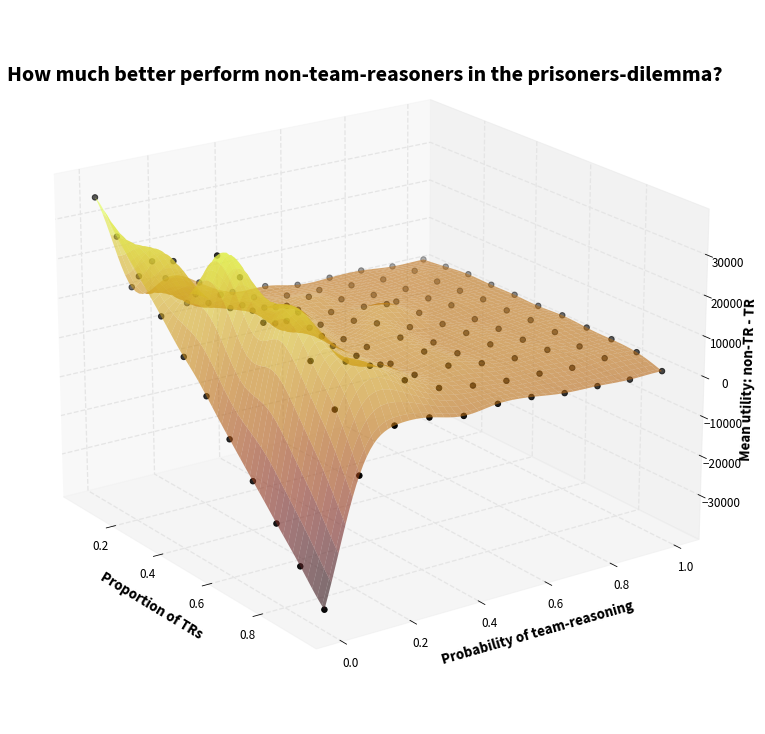

<IPython.core.display.Javascript object>

In [19]:
plt.style.use("opinions.mplstyle")
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20,-35)

import cmocean


spline = scipy.interpolate.Rbf(difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["performance_diff"],function='multiquadric')#,smooth=1)#, epsilon=2)

x_grid = np.linspace(np.min(difference_frame["proportion_team_reasoners"]), np.max(difference_frame["proportion_team_reasoners"]),100)
y_grid = np.linspace(np.min(difference_frame["probability_team_reasoning"]), np.max(difference_frame["probability_team_reasoning"]),100)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = spline(B1,B2)

ax.plot_surface(B1, B2, Z,alpha=.6,cmap=cmocean.cm.solar)
ax.scatter(
    difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["performance_diff"],
    s=30,c='black'#,alpha= 1
)

plt.title("How much better perform non-team-reasoners in the prisoners-dilemma?",y=.87)


plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)
ax.set_zlabel("Mean utility: non-TR - TR")
# ax.invert_xaxis()



Text(0.5, 0, 'Final number of TRs')

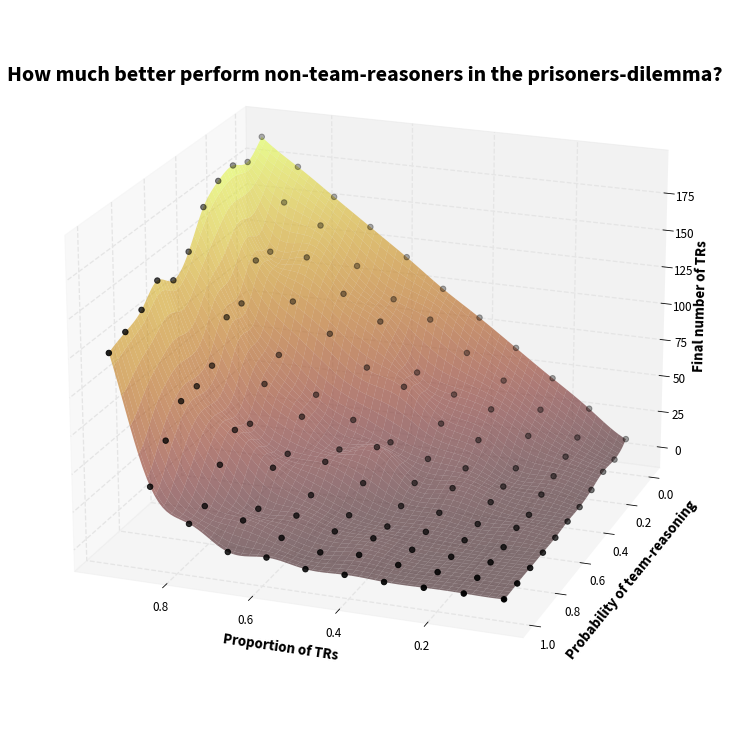

<IPython.core.display.Javascript object>

In [20]:
plt.style.use("opinions.mplstyle")
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20,110)

import cmocean


spline = scipy.interpolate.Rbf(difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["final_tr_share"],function='multiquadric')#,smooth=1)#, epsilon=2)

x_grid = np.linspace(np.min(difference_frame["proportion_team_reasoners"]), np.max(difference_frame["proportion_team_reasoners"]),100)
y_grid = np.linspace(np.min(difference_frame["probability_team_reasoning"]), np.max(difference_frame["probability_team_reasoning"]),100)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = spline(B1,B2)

ax.plot_surface(B1, B2, Z,alpha=.6,cmap=cmocean.cm.solar)
ax.scatter(
    difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["final_tr_share"],
    s=30,c='black'#,alpha= 1
)

plt.title("How much better perform non-team-reasoners in the prisoners-dilemma?",y=.87)


plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)
ax.set_zlabel("Final number of TRs")
# ax.invert_xaxis()



Text(0.5, 0, 'Length of simulation')

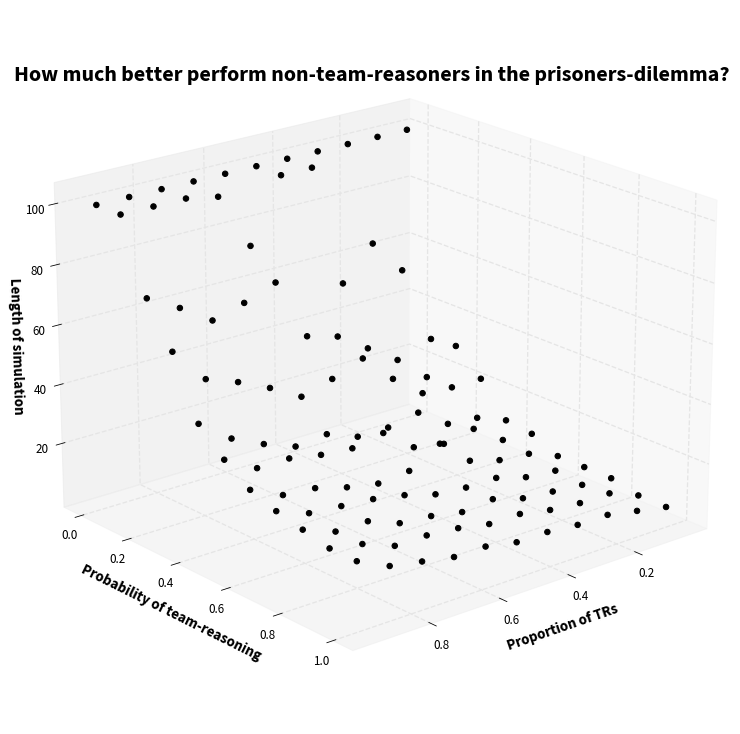

<IPython.core.display.Javascript object>

In [25]:
plt.style.use("opinions.mplstyle")
fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20,50)

import cmocean


spline = scipy.interpolate.Rbf(difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["amount_of_steps"])#,function='multiquadric',smooth=.1)#, epsilon=2)

x_grid = np.linspace(np.min(difference_frame["proportion_team_reasoners"]),
                     np.max(difference_frame["proportion_team_reasoners"]),21)
y_grid = np.linspace(np.min(difference_frame["probability_team_reasoning"]),
                     np.max(difference_frame["probability_team_reasoning"]),21)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = spline(B1,B2)
# print(Z)

# ax.plot_surface(B1, B2, Z,alpha=.6,cmap=cmocean.cm.solar)
# ax.plot_wireframe(difference_frame["proportion_team_reasoners"],
#                 difference_frame["probability_team_reasoning"],
#                   ,alpha=.6,cmap=cmocean.cm.solar)


ax.scatter(
    difference_frame["proportion_team_reasoners"],
    difference_frame["probability_team_reasoning"],
    difference_frame["amount_of_steps"],
    s=30,c='black',alpha= 1
)

plt.title("How much better perform non-team-reasoners in the prisoners-dilemma?",y=.87)


plt.xlabel("Proportion of TRs", labelpad=10)
plt.ylabel("Probability of team-reasoning", labelpad=10)
ax.set_zlabel("Length of simulation")
# ax.invert_xaxis()



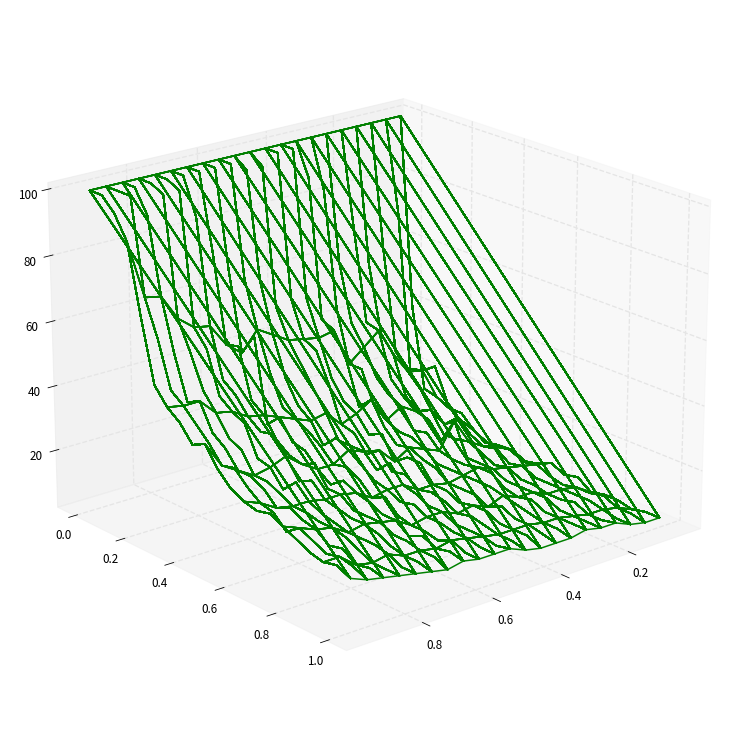

<IPython.core.display.Javascript object>

In [127]:
from scipy.interpolate import griddata

fig = plt.figure(figsize=(10, 10))
ax = axes3d.Axes3D(fig)
ax.view_init(20, 50)
x = difference_frame["proportion_team_reasoners"]
y = difference_frame["probability_team_reasoning"]
z = difference_frame["amount_of_steps"]

X, Y = np.meshgrid(x, y)
Z = griddata((x, y), z, (X, Y), method="nearest")


ax.plot_wireframe(X, Y, Z, color="green")

plt.show()